In [1]:
import pandas as pd

df = pd.read_csv("/Users/ebenezer/Documents/SleepApnea/Alldata/consolidated/summary_all_df.csv", delimiter=",")


In [12]:
!pwd

/Users/ebenezer


In [2]:
# 2. Identify Obstructive Apnea event start times and start-position for all subjects
oa_events = (
    df[df["Event name"] == "Obstructive Apnea"]
      .sort_values("Timestamp")
      .groupby(["Subject", "Rank"], as_index=False)
      .agg(
          Apnea_Start=("Timestamp", "first"),
          Position_Start=("Position_median", "first")
      )
)
oa_events = oa_events.rename(columns={"Rank": "OA_Rank"})
oa_events.head(3)

,Subject,OA_Rank,Apnea_Start,Position_Start
0,1,2,2024-10-31 22:23:30,Supine
1,1,3,2024-10-31 22:24:26,Supine
2,1,4,2024-10-31 22:25:41,Supine


In [3]:
df.head(1)


,Subject,Timestamp,Value,Event name,Rank,Post_5,Pre_5,Post_10,Pre_10,Systolic_median,Systolic_mode,SpO2_median,Position_median,HeartRate_median,Diastolic_median
0,1,2024-10-31 22:21:30,0.0,NaN,0,0,0.0,0,0.0,189.0,Wake,0.0,Supine,83.5,125.0


In [4]:

# Step 2: Merge and compute pre-event statistics
pre_stats = (
    df
      .merge(
          oa_events[["Subject", "OA_Rank"]],
          left_on=["Subject", "Pre_5"],
          right_on=["Subject", "OA_Rank"],
          how="inner"
      )
      .query("SpO2_median != 0")
      .groupby(["Subject", "OA_Rank"], as_index=False)
      .agg(
          Mean_Pre_SBP=("Systolic_median", "mean"),
          Mean_Pre_HR=("HeartRate_median", "mean"),
          Mean_Pre_SpO2=("SpO2_median", "mean")
      )
)

In [5]:
pre_stats

,Subject,OA_Rank,Mean_Pre_SBP,Mean_Pre_HR,Mean_Pre_SpO2
0,1,3,203.7,92.4,94.0
1,1,4,187.9,83.3,93.8
2,1,5,186.9,85.3,92.4
3,1,24,197.8,77.9,89.6
4,1,51,194.3,71.3,91.0
...,...,...,...,...,...
1557,30,197,133.2,88.2,98.2
1558,30,212,0.0,66.6,87.6
1559,30,233,0.0,74.4,98.0
1560,30,234,26.4,82.6,95.0


In [6]:
post_spo2_series = (
    df
    .merge(oa_events[["Subject", "OA_Rank"]],
           left_on=["Subject", "Post_5"], right_on=["Subject", "OA_Rank"],
           how="inner")
    .query("Systolic_median != 0 and Position_median != 'Upright'")
    .groupby(["Subject", "OA_Rank"])
    .agg({
        "SpO2_median": lambda x: list(x),
        "Timestamp": lambda x: list(x)
    })
    .reset_index()
    .rename(columns={"SpO2_median": "SpO2_List", "Timestamp": "Timestamp_List"})
)


In [7]:
post_spo2_series

,Subject,OA_Rank,SpO2_List,Timestamp_List
0,1,2,"[92.0, 92.0, 92.0, 92.0, 92.0, 92.0, 92.0, 92....","[2024-10-31 22:23:30, 2024-10-31 22:23:31, 202..."
1,1,3,"[94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 94....","[2024-10-31 22:24:26, 2024-10-31 22:24:27, 202..."
2,1,4,"[94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 94....","[2024-10-31 22:25:41, 2024-10-31 22:25:42, 202..."
3,1,5,"[93.0, 93.0, 94.0, 94.0, 94.0, 95.0, 95.0, 95....","[2024-10-31 22:27:10, 2024-10-31 22:27:11, 202..."
4,1,24,"[91.0, 91.0, 91.0, 91.0, 91.0, 91.0, 91.0, 91....","[2024-10-31 23:23:58, 2024-10-31 23:23:59, 202..."
...,...,...,...,...
1912,30,145,"[98.0, 98.0, 99.0]","[2025-04-12 06:14:37, 2025-04-12 06:14:38, 202..."
1913,30,153,"[99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]","[2025-04-12 06:23:42, 2025-04-12 06:23:43, 202..."
1914,30,187,"[98.0, 98.0, 98.0]","[2025-04-12 07:06:15, 2025-04-12 07:06:16, 202..."
1915,30,197,"[98.0, 98.0, 98.0, 98.0, 98.0]","[2025-04-12 07:23:13, 2025-04-12 07:23:14, 202..."


In [8]:
comparison = (
    oa_events
      .merge(pre_stats, on=["Subject","OA_Rank"])
      .merge(post_spo2_series, on=["Subject","OA_Rank"])
)

comparison


,Subject,OA_Rank,Apnea_Start,Position_Start,Mean_Pre_SBP,Mean_Pre_HR,Mean_Pre_SpO2,SpO2_List,Timestamp_List
0,1,3,2024-10-31 22:24:26,Supine,203.7,92.4,94.0,"[94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 94....","[2024-10-31 22:24:26, 2024-10-31 22:24:27, 202..."
1,1,4,2024-10-31 22:25:41,Supine,187.9,83.3,93.8,"[94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 94....","[2024-10-31 22:25:41, 2024-10-31 22:25:42, 202..."
2,1,5,2024-10-31 22:27:10,Supine,186.9,85.3,92.4,"[93.0, 93.0, 94.0, 94.0, 94.0, 95.0, 95.0, 95....","[2024-10-31 22:27:10, 2024-10-31 22:27:11, 202..."
3,1,24,2024-10-31 23:23:58,Right,197.8,77.9,89.6,"[91.0, 91.0, 91.0, 91.0, 91.0, 91.0, 91.0, 91....","[2024-10-31 23:23:58, 2024-10-31 23:23:59, 202..."
4,1,51,2024-10-31 23:54:10,Supine,194.3,71.3,91.0,"[91.0, 91.0, 91.0, 90.0, 90.0, 90.0, 90.0, 90....","[2024-10-31 23:54:10, 2024-10-31 23:54:11, 202..."
...,...,...,...,...,...,...,...,...,...
1496,30,145,2025-04-12 06:14:37,Supine,141.8,70.0,98.0,"[98.0, 98.0, 99.0]","[2025-04-12 06:14:37, 2025-04-12 06:14:38, 202..."
1497,30,153,2025-04-12 06:23:42,Left,108.8,78.6,98.0,"[99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]","[2025-04-12 06:23:42, 2025-04-12 06:23:43, 202..."
1498,30,187,2025-04-12 07:06:15,Left,139.8,81.8,98.0,"[98.0, 98.0, 98.0]","[2025-04-12 07:06:15, 2025-04-12 07:06:16, 202..."
1499,30,197,2025-04-12 07:23:13,Supine,133.2,88.2,98.2,"[98.0, 98.0, 98.0, 98.0, 98.0]","[2025-04-12 07:23:13, 2025-04-12 07:23:14, 202..."


In [9]:
comparison

,Subject,OA_Rank,Apnea_Start,Position_Start,Mean_Pre_SBP,Mean_Pre_HR,Mean_Pre_SpO2,SpO2_List,Timestamp_List
0,1,3,2024-10-31 22:24:26,Supine,203.7,92.4,94.0,"[94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 94....","[2024-10-31 22:24:26, 2024-10-31 22:24:27, 202..."
1,1,4,2024-10-31 22:25:41,Supine,187.9,83.3,93.8,"[94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 94....","[2024-10-31 22:25:41, 2024-10-31 22:25:42, 202..."
2,1,5,2024-10-31 22:27:10,Supine,186.9,85.3,92.4,"[93.0, 93.0, 94.0, 94.0, 94.0, 95.0, 95.0, 95....","[2024-10-31 22:27:10, 2024-10-31 22:27:11, 202..."
3,1,24,2024-10-31 23:23:58,Right,197.8,77.9,89.6,"[91.0, 91.0, 91.0, 91.0, 91.0, 91.0, 91.0, 91....","[2024-10-31 23:23:58, 2024-10-31 23:23:59, 202..."
4,1,51,2024-10-31 23:54:10,Supine,194.3,71.3,91.0,"[91.0, 91.0, 91.0, 90.0, 90.0, 90.0, 90.0, 90....","[2024-10-31 23:54:10, 2024-10-31 23:54:11, 202..."
...,...,...,...,...,...,...,...,...,...
1496,30,145,2025-04-12 06:14:37,Supine,141.8,70.0,98.0,"[98.0, 98.0, 99.0]","[2025-04-12 06:14:37, 2025-04-12 06:14:38, 202..."
1497,30,153,2025-04-12 06:23:42,Left,108.8,78.6,98.0,"[99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]","[2025-04-12 06:23:42, 2025-04-12 06:23:43, 202..."
1498,30,187,2025-04-12 07:06:15,Left,139.8,81.8,98.0,"[98.0, 98.0, 98.0]","[2025-04-12 07:06:15, 2025-04-12 07:06:16, 202..."
1499,30,197,2025-04-12 07:23:13,Supine,133.2,88.2,98.2,"[98.0, 98.0, 98.0, 98.0, 98.0]","[2025-04-12 07:23:13, 2025-04-12 07:23:14, 202..."


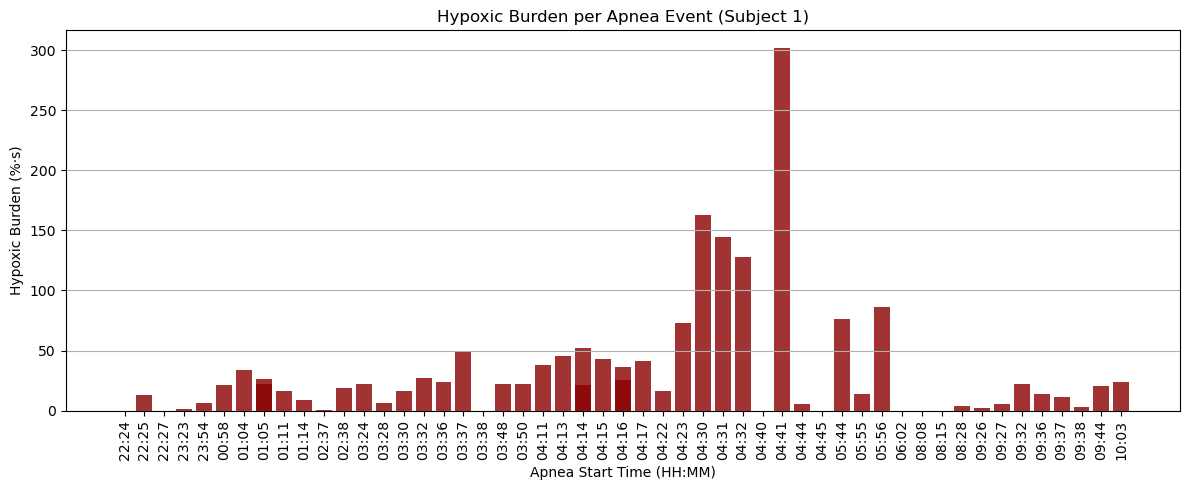

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import trapz

# Step 1: Recompute Hypoxic Burden per Apnea Event
comparison_with_burden = comparison.copy()

hypoxic_burden = []
for _, row in comparison_with_burden.iterrows():
    spo2_values = np.array(row["SpO2_List"], dtype=float)
    timestamps = pd.to_datetime(row["Timestamp_List"])
    mean_pre_spo2 = row["Mean_Pre_SpO2"]

    # Convert timestamps to seconds
    time_seconds = (timestamps - timestamps[0]).total_seconds()

    # Compute hypoxic burden: only the area below baseline
    delta_spo2 = mean_pre_spo2 - spo2_values
    auc = trapz(y=np.clip(delta_spo2, a_min=0, a_max=None), x=time_seconds)
    hypoxic_burden.append(auc)

# Add back to dataframe
comparison_with_burden["Hypoxic_Burden"] = hypoxic_burden

# Step 2: Filter for one subject
subject_id = 1
df_subject = comparison_with_burden[comparison_with_burden["Subject"] == subject_id].copy()

# Ensure Apnea_Start is in datetime format
df_subject["Apnea_Start"] = pd.to_datetime(df_subject["Apnea_Start"])
df_subject = df_subject.sort_values("Apnea_Start")

# Step 3: Plot using Apnea Start time as x-axis
plt.figure(figsize=(12, 5))
x_labels = df_subject["Apnea_Start"].dt.strftime("%H:%M")

plt.bar(x_labels, df_subject["Hypoxic_Burden"], color='darkred', alpha=0.8)
plt.xlabel("Apnea Start Time (HH:MM)")
plt.ylabel("Hypoxic Burden (%·s)")
plt.title(f"Hypoxic Burden per Apnea Event (Subject {subject_id})")
plt.xticks(rotation=90)
plt.grid(axis="y")
plt.tight_layout()
plt.show()